In [1]:
## PART 3 - SEAM CARVING - SINTESIS D'IMATGES.
%matplotlib inline

In [2]:
# carreguem totes les llibreries necesaries per a la practica
from skimage import data, draw, color, data, restoration, filters,transform, util
from scipy import misc, fftpack, signal
from scipy.misc import imresize
from scipy import ndimage as nd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.animation as animation
import scipy

In [3]:
#normalitzacio d'imatge
def normalitzar(imatge):
    return np.real((imatge - np.min(imatge)) * 256 / (np.max(imatge) - np.min(imatge)))

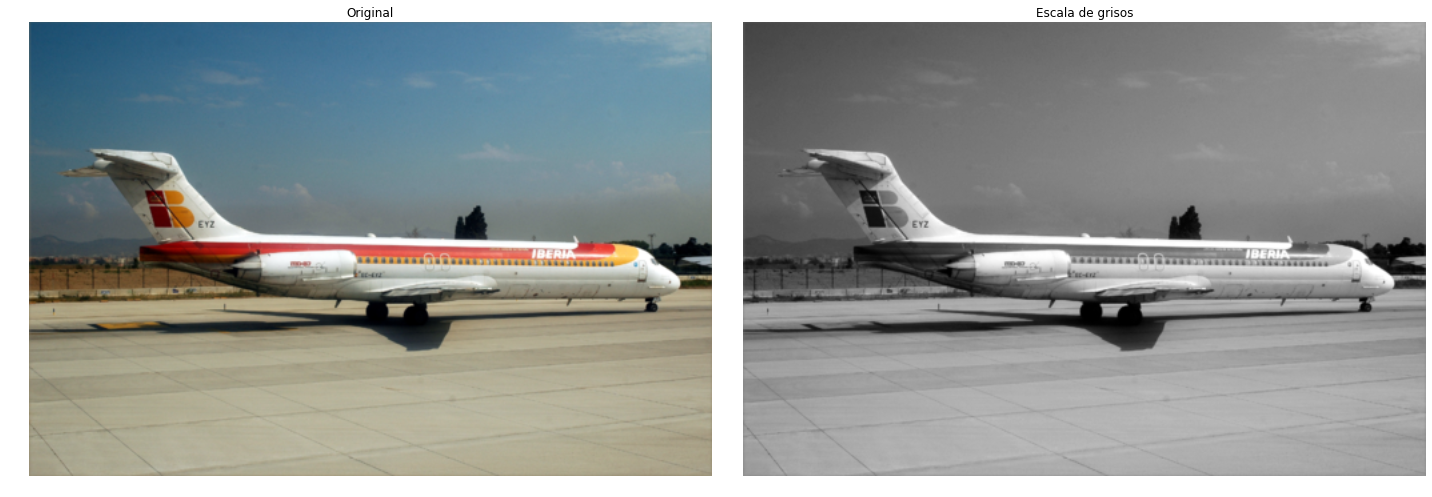

In [4]:
RGB = plt.imread('iberia.jpg')
scale_factor = 2
RGB = imresize(RGB, ( RGB.shape[0]/scale_factor, RGB.shape[1]/scale_factor,3),interp='bilinear').astype('float')
img = color.rgb2gray(RGB)

# Visualitzem la imatge original i la imatge en escala de grisos
fig = plt.figure(1) 
plt.subplot(1,2,1)
plt.imshow(RGB.astype('uint8'))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(normalitzar(img), cmap="gray")
plt.title('Escala de grisos')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()

In [5]:
def gradient(img):
    img = color.rgb2gray(img)
    gx, gy = np.gradient(img)
    grad = np.sqrt(gx*gx + gy*gy)
    return grad

#Calcul matriu d'energia que acomulada te cada zona
def energia(imatge):
    height,width = imatge.shape
    energia=np.zeros(imatge.shape)
    #asignem la primera linea igual que la imatge que tenim
    energia[0]=imatge[0]   
    for x in range(1,height):
        for y in range(0,width):
            if y == 0:#inici de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
            elif y < width - 2:#abans del final de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y+1] )
                min_val = min( min_val, energia[x-1, y-1] )
            else:#final de la imatge
                min_val = min( energia[x-1, y], energia[x-1, y-1] )
            energia[x,y] = imatge[x,y] + min_val#valor acomulat d'energia
    return energia

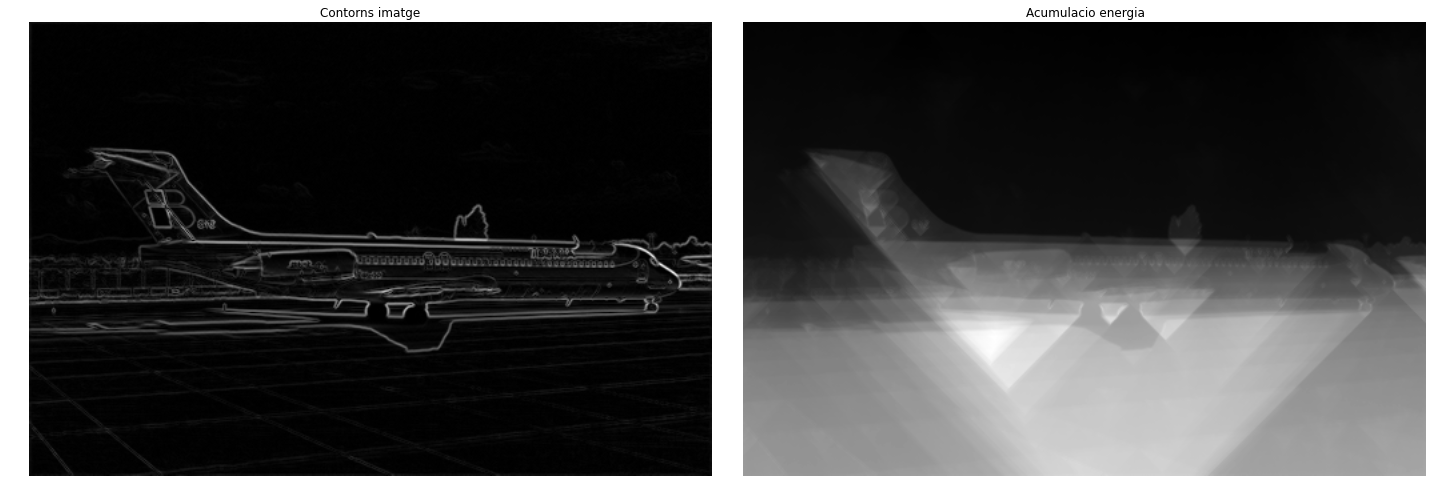

In [6]:
grad = gradient(img)
energy = energia(grad)

#Visualization
fig = plt.figure(2) 
plt.subplot(1,2,1)
plt.imshow(normalitzar(grad), cmap="gray")
plt.title('Contorns imatge')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(normalitzar(energy), cmap="gray" )
plt.title('Acumulacio energia')
plt.axis('off')
plt.gcf().set_size_inches((20,20))
fig.tight_layout()
plt.show()


In [7]:
# El calcul del tall vertical hem de buscar el cami amb cost minim. BACKTRACKING
# Aquest tall pot ser vertical o horitzontal, es un camí de pixels connectats. En el nostre cas l'apliquem vertical
# La función de importancia / energía valora un píxel mediante la medición de su contraste con sus píxeles vecinos.
# Des de la imatge en escala de grisos retornarem el tall vertical mes baix com a llista de pixels

def tall_vertical(im, it):
    # Anem fins al -1 perque aixi es quedara en el 0, que tambe el necessitem.
    width, height = im.shape
    cost = energia(gradient(im))
    
    paths = []
    visited = []
    
    # passem per totes les iteracions a fer
    for i in range(it):
        # assignem un valor, al min_val
        min_val = np.max(cost)+1
        path = []
        
        for y in range(height):
            # si el seam es menor que le valor minim i no esta en el vector de visitats.
            if cost[width-1,y] < min_val and y not in visited :
                min_val = cost[width-1,y]
                min_ptr = y
        
        # Afegim al vector de visitats
        visited.append(min_ptr)
        pos = (width-1, min_ptr)
        path.append(pos)
        
        while pos[0] != 0:
            val = cost[pos] - grad[pos]
            x,y = pos
            if y == 0:
                if val == cost[x-1,y+1]:
                    pos = (x-1,y+1) 
                else:
                    pos = (x-1,y)
            elif y <= height - 2:
                if val == cost[x-1,y+1]:
                    pos = (x-1,y+1) 
                elif val == cost[x-1,y]:
                    pos = (x-1,y)
                else:
                    pos = (x-1,y-1)
            else:
                if val == cost[x-1,y]:
                    pos = (x-1,y)
                else:
                    pos = (x-1,y-1) 

            path.append(pos)
        
        print "iteration",i,"-",path[0][1]
        paths.append(path)
  

    return paths


def mark_seam (mat, path, mark_as='red'):
    #Dono maxim valor al canal corresponent al color escollit a tots els pixels del path que ens marca el cami a borrar
    for i in path:
        if mark_as == 'red':
            mat[i] = (255,0,0)
        elif mark_as == 'green':
            mat[i] = (0,255,0)
        elif mark_as == 'blue':
            mat[i] = (0,0,255)
        elif mark_as == 'white':
            mat[i] = (255,255,255)
        elif mark_as == 'black':
            mat[i] = (0,0,0)
    
    return mat; 

# fem un calcul de la mitja dels valors
def vector_mitja(u, v):
    w = u.astype('uint16')
    for i in range(len(w)):
        w[i] = (w[i] + v[i])/2

    return w.astype('uint8')

# Funcio per afegir el seam vertical
def afegir_seam(img, path):
    height, width = img.shape[:2]
    # creem una matriu de la mateixa mida
    i = np.zeros((height, width+1, img.shape[2]))
    
    path_set = set(path)
    seen_set = set()
    
    # recorrem y anem asignam els seams, sempre fent una mitja del vector
    for x in xrange(height):
        for y in xrange(width):
            if (x,y) not in path_set and x not in seen_set:
                i[x,y] = img[x,y]
            elif (x,y) in path_set and x not in seen_set:
                i[x,y] = img[x,y]
                seen_set.add(x)
                if y <= width - 2:
                    i[x,y+1] = vector_mitja(img[x,y], img[x,y+1])
                else:
                    i[x,y+1] = vector_mitja(img[x,y], img[x,y-1])
            else:
                i[x,y+1] = img[x,y]

    return i

In [8]:
# Funcio que s'encarregara de mirar les linees verticals que hi ha (seams), marcar els seams i afegir-los
def carving(iteracio,rgb):
    result = rgb.copy();
    seams = []

    gray = color.rgb2gray(rgb)
    path = tall_vertical(gray,iteracio)

    for p in path:
        rgb = mark_seam(rgb, p, 'blue')
        seams.append([plt.imshow(rgb.astype('uint8'))])
        result = afegir_seam(result, p)

    return result, seams;

iteration 0 - 56
iteration 1 - 58
iteration 2 - 48
iteration 3 - 59
iteration 4 - 57
iteration 5 - 51
iteration 6 - 52
iteration 7 - 55
iteration 8 - 49
iteration 9 - 54
iteration 10 - 45
iteration 11 - 53
iteration 12 - 60
iteration 13 - 46
iteration 14 - 47
iteration 15 - 42
iteration 16 - 50
iteration 17 - 41
iteration 18 - 40
iteration 19 - 61
iteration 20 - 43
iteration 21 - 44
iteration 22 - 39
iteration 23 - 37
iteration 24 - 34
iteration 25 - 62
iteration 26 - 36
iteration 27 - 38
iteration 28 - 63
iteration 29 - 35
iteration 30 - 64
iteration 31 - 66
iteration 32 - 67
iteration 33 - 65
iteration 34 - 33
iteration 35 - 68
iteration 36 - 104
iteration 37 - 69
iteration 38 - 106
iteration 39 - 105
iteration 40 - 30
iteration 41 - 75
iteration 42 - 70
iteration 43 - 3
iteration 44 - 6
iteration 45 - 0
iteration 46 - 71
iteration 47 - 72
iteration 48 - 7
iteration 49 - 2
iteration 50 - 103
iteration 51 - 4
iteration 52 - 12
iteration 53 - 74
iteration 54 - 102
iteration 55 - 76
ite

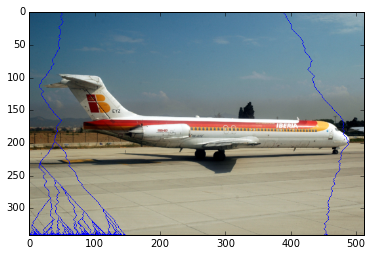

In [9]:
# truquem a la funcio carving, que sera la que s'encarregara de fer tot el proces de cerca dels seams i adessio de les noves
# linees a l'imatge
fig = plt.figure(3)
result, seams = carving(150, RGB.copy());
print result.shape

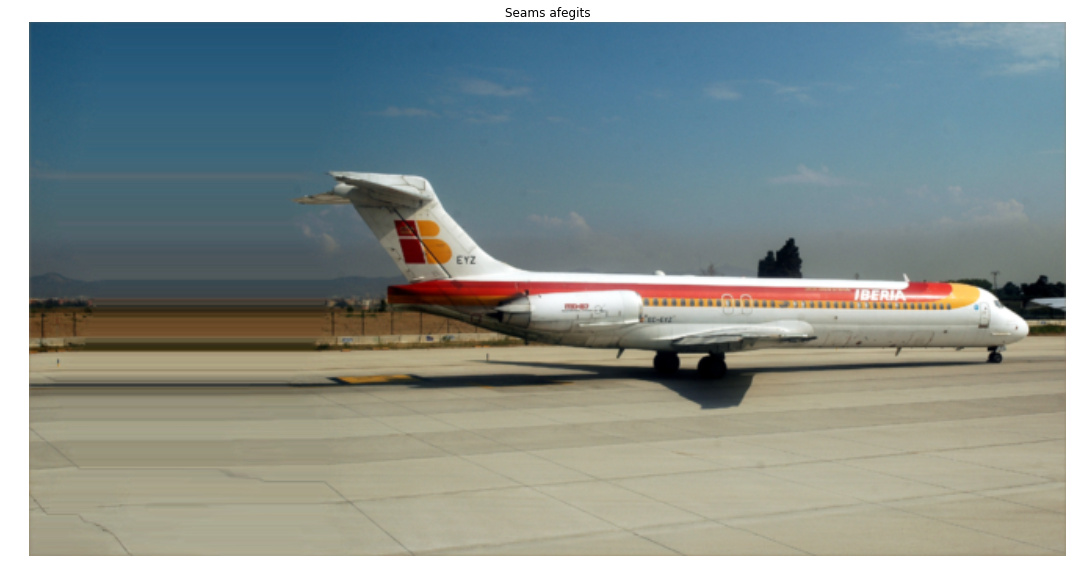

In [10]:
# Visualitzacio de com quedaria afegint seams
fig = plt.figure(4) 
plt.imshow(result.astype('uint8'))
plt.title('Seams afegits')
plt.axis('off')
plt.gcf().set_size_inches((15,15))
fig.tight_layout()
scipy.misc.imsave('inserccion_final.jpg', result)